In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.signal import savgol_filter
%matplotlib inline

In [2]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
disp_figs = True

In [4]:
M = 4 # Number of Spiking motifs
N = 10 # Number of input neurons
D = 31 # temporal depth of receptive field
T = 1000
dt = 1
nrn_fr = 40 # hz
pg_fr = 4 # hz
background_noise_fr = 0 # h

np.random.seed(41)

In [5]:
# for matplotlib
colors = np.array(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
len(colors)

10

# Generate the PG Kernels


In [6]:
# I will try and do this with dense and sparse representations at the same time
# Dense K: matrix of binary images of sizeNxDxM
# Sparse K: set of (delay d, neuron a, and pg b)

K_dense = np.random.randint(0,999,(N,D,M))
K_dense[K_dense < nrn_fr] = 1
K_dense[K_dense >= nrn_fr] = 0
K_sparse = np.where(K_dense)

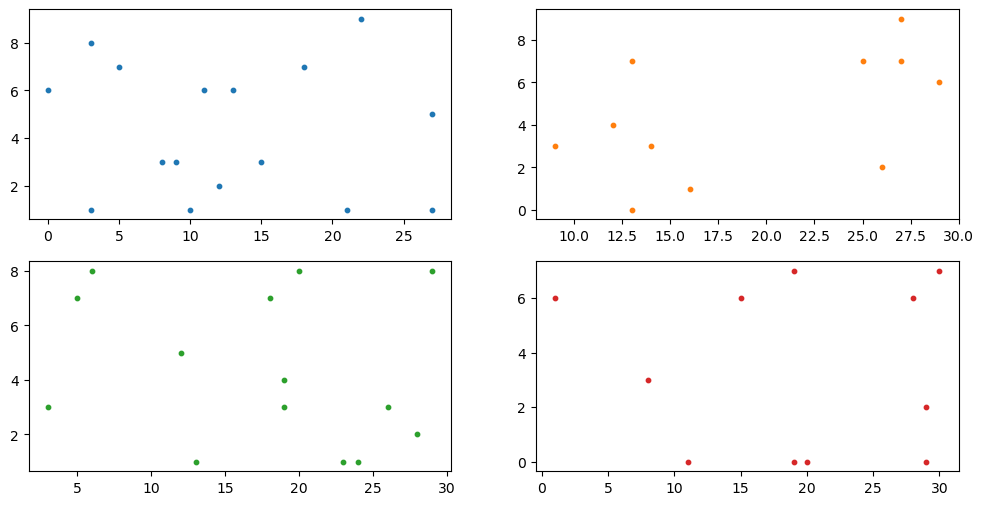

In [7]:

if disp_figs:
    %matplotlib inline
    fig,ax = plt.subplot_mosaic('AB;CD',figsize=(12,6))
    [ax[k].scatter(K_sparse[1][K_sparse[2]==i], K_sparse[0][K_sparse[2]==i],c=colors[i],s=10) for i,k in enumerate(['A','B','C','D'])]

# Generate the PG occurrences

In [8]:
# I suppose I can also do this in sparse and dense
# dense B: the binary image of the occurrences of the spiking motif as a ( M x T) matrix
# spare B: set of all times t and pg's b
B_dense = np.random.randint(0,999,(M,T))
B_dense[B_dense < pg_fr] = 1
B_dense[B_dense >= pg_fr] = 0
B_sparse = np.where(B_dense)

In [9]:
B_sparse[0]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 3, 3], dtype=int64)

In [10]:
colors[B_sparse[0]]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e',
       '#ff7f0e', '#ff7f0e', '#2ca02c', '#d62728', '#d62728'], dtype='<U7')

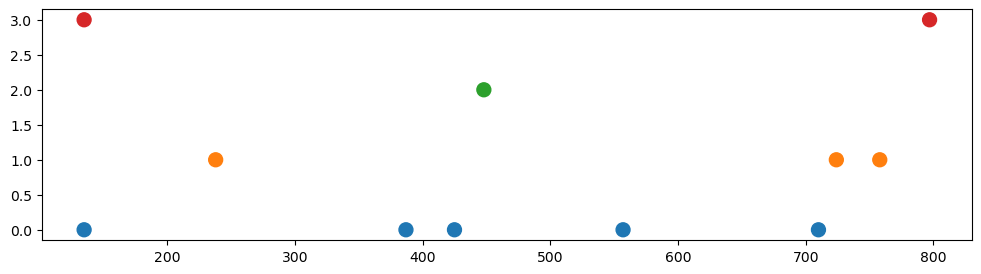

In [11]:
plt.figure(figsize=(12,3))
plt.scatter(B_sparse[1],B_sparse[0],c=colors[B_sparse[0]],s=100)
plt.show()

# Convolve the PG kernels with the PG firing times

In [12]:
background_noise_fr

0

In [13]:
# now to make the full raster plot keeping the labels in-tact
# dense A: the layered binary images of all neuron spikes by PG ( N x T x M
A_dense = np.zeros((N,T+D,M+1))
A_dense[...,-1] = np.random.randint(0,999,(N,T+D))
A_dense[...,-1] = (A_dense[...,-1] < background_noise_fr).astype('int')
for i in range(len(B_sparse[0])):
    t = B_sparse[1][i]
    b = B_sparse[0][i]
    A_dense[:, t:t+D, b] += K_dense[...,b]
    
A_dense.shape
# A_dense = A_dense[:,:1000,:]
A_sparse = np.where(A_dense)
A_dense = np.sum(A_dense,axis=2)
A_dense[A_dense>1] = 1
A_dense.shape

(10, 1031)

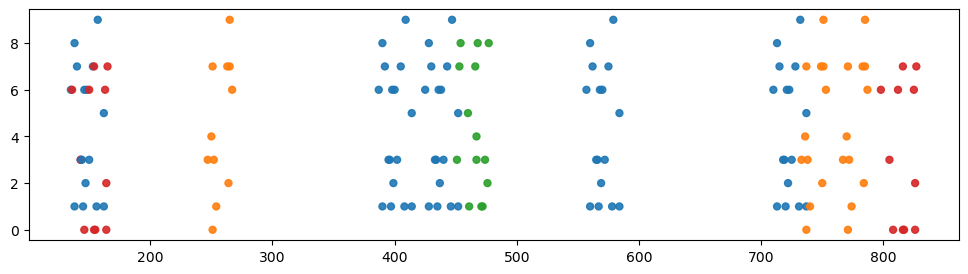

In [14]:
%matplotlib inline
plt.figure(figsize=(12,3))
plt.scatter(A_sparse[1],A_sparse[0],c=colors[A_sparse[2]],alpha=0.9,s=100,marker='.')
plt.show()

# Sanity Check

Let's start with a proof of concept by convolving the answers with the full raster plot :)

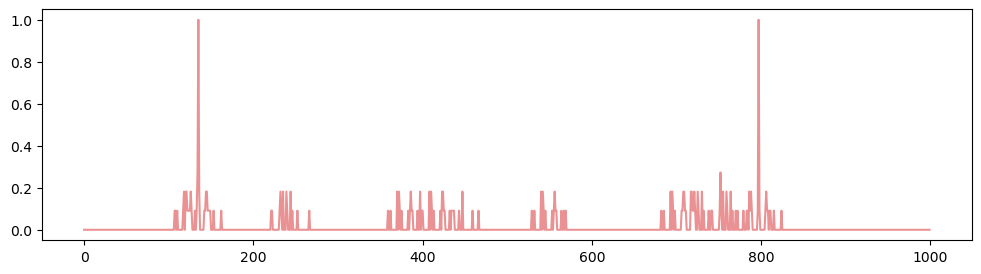

In [15]:
test = np.zeros((T,M))
%matplotlib inline
for j in range(M):
    for i in range(T):
        test[i,j] = np.sum(K_dense[...,j]*A_dense[:,i:i+D])
    test[:,j] = test[:,j]/np.max(test[:,j])
plt.figure(figsize=(12,3))
i = 3
plt.plot(test[:,i],color=colors[i],alpha=0.5)

# Unsupervised Learning

so... why don't I try the flawed window shift method? Even though this loses the spike information

In [16]:
window_dim = (int(np.ceil(D/2)), N)
valid_spikes = (A_sparse[1] > window_dim[0]) & (A_sparse[1] < T- window_dim[0])

 should make sure to have the labels handy...

In [17]:
M_labels = A_sparse[2][valid_spikes]
N_labels = A_sparse[0][valid_spikes]
T_labels = A_sparse[1][valid_spikes]
windows = np.zeros((len(T_labels), N, window_dim[0]*2))
for i,window_time in enumerate(T_labels):
    windows[i,...] = A_dense[:,-window_dim[0]+window_time:window_dim[0]+window_time]
    windows[i,N_labels[i],window_dim[0]] = 2
print('spikes: %d, neurons: %s, depth: %a' %windows.shape)

spikes: 149, neurons: 10, depth: 32


In [18]:
windows.shape

(149, 10, 32)

# Cross correlation of the windows??

In [19]:
test = windows[N_labels==2]
test.shape

(11, 10, 32)

In [20]:
result = np.zeros((test.shape[0],test.shape[0],10,32))

In [21]:
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        result[i,j,...] = test[i]*test[j]


In [22]:
x = np.sum(result,axis=(2,3))

In [24]:
test.shape

(11, 10, 32)

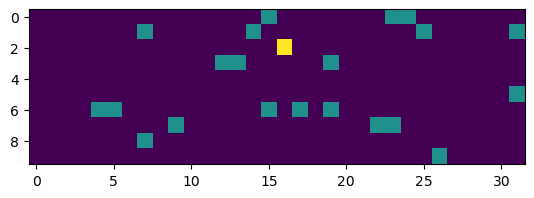

In [30]:
plt.figure()
plt.imshow(test[0,...])

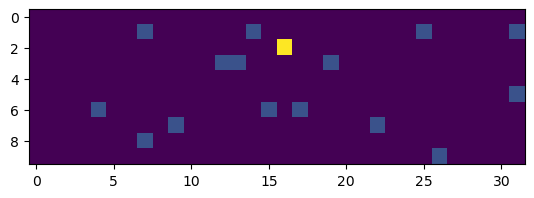

In [28]:
plt.figure()
plt.imshow(result[7,0])

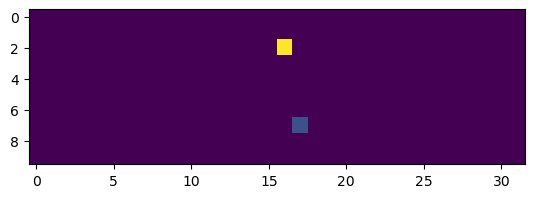

In [29]:
plt.figure()
plt.imshow(result[8,1])

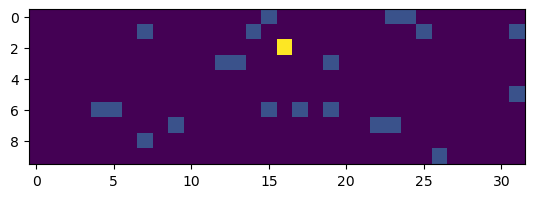

In [30]:
plt.figure()
plt.imshow(result[0,0])

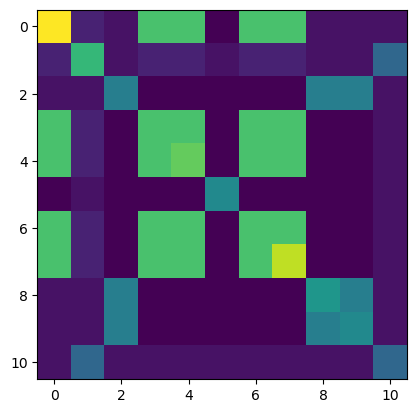

In [31]:
plt.figure()
plt.imshow(x)

For each spike, I can guess if there is a pattern repeating around it based off of the dot product between the two windows of that point... So in the above matrix I see that 5 spikes correlate highly with 4 OTHER spikes, 2 spikes correlate with just 1 OTHER spike, and 3 spikes correlate with 2 OTHER spikes. so... How can I take this data and do some clustering with it? hmmmmm...



What about PCA/t-sne on the window products? What is the product of two windows though? (actually it's the spiking motif...)


In [32]:
pca_test_data = result.reshape(11*11,10*32)
print(pca_test_data.shape, "trials and components")

(121, 320) trials and components


In [33]:
import pandas as pd
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [34]:
z_windows = zscore(pca_test_data,axis=1)
z_windows[np.isnan(z_windows)] = 0
z_windows.shape

(121, 320)

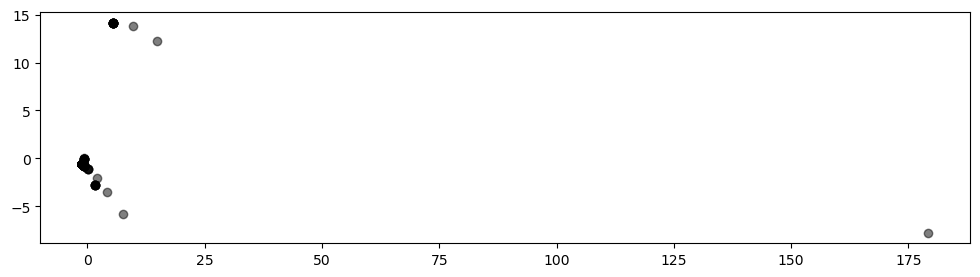

In [35]:

%matplotlib inline
pca = PCA(n_components=2)
pca_features2 = pca.fit_transform(np.transpose(z_windows))
pca_df = pd.DataFrame(data=pca_features2, columns=['PC1', 'PC2'])
fig,ax = plt.subplot_mosaic('A',figsize=(12,3))
ax['A'].scatter(*pca_features2.T,c='black',alpha=0.5)
plt.show()

In [39]:
%matplotlib qt
pca = PCA(n_components=3)
pca_features3 = pca.fit_transform(np.transpose(z_windows.T))
pca_df = pd.DataFrame(data=pca_features3, columns=['PC1', 'PC2','PC3'])
fig = plt.figure(figsize=(12,3))
ax[0] = fig.add_subplot(121, projection='3d')
# ax[1] = fig.add_subplot(122, projection='3d')
ax[0].scatter(*pca_features3.T,c='black',alpha=0.5,s=10)
# ax[1].scatter(*pca_features3.T,c=colors[M_labels[N_labels==2]],alpha=0.5,s=10)
plt.show()

In [121]:
%matplotlib inline
n_components=np.min(z_windows.shape)
pca = PCA(n_components=n_components)
pca_features3 = pca.fit_transform(z_windows.T)
columns=['PC%d'%i for i in range(1,1+n_components)]
pca_df = pd.DataFrame(data=pca_features3, columns=columns)
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

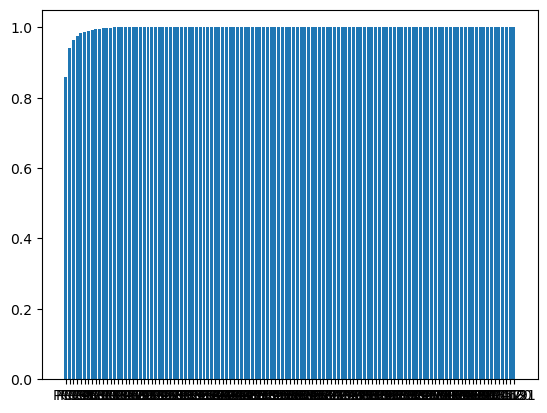

In [48]:
plt.figure()
plt.bar(columns,np.cumsum(pca.explained_variance_ratio_))
plt.show()

Test pca directly on the raw data (not cross-correlated data?)

In [53]:
test = test.reshape(11,10*32)
test.shape

(11, 320)

In [54]:
z_windows = zscore(test,axis=1)
z_windows[np.isnan(z_windows)] = 0
z_windows.shape

(11, 320)

In [62]:
pca_features2.T[0].shape

(320,)

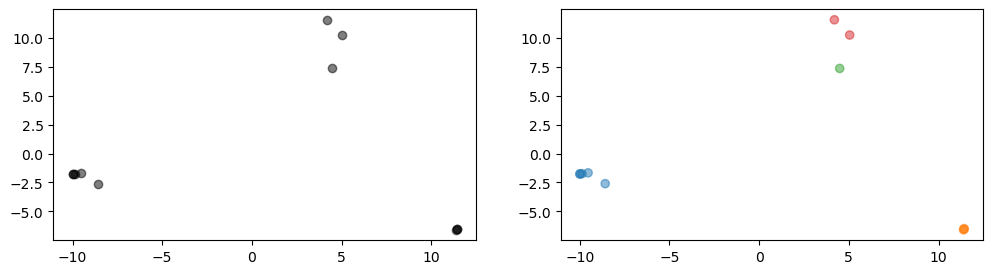

In [66]:
%matplotlib inline
pca = PCA(n_components=2)
pca_features2 = pca.fit_transform(z_windows)
pca_df = pd.DataFrame(data=pca_features2, columns=['PC1', 'PC2'])
fig,ax = plt.subplot_mosaic('AB',figsize=(12,3))
ax['A'].scatter(*pca_features2.T,c='black',alpha=0.5)
ax['B'].scatter(*pca_features2.T,c=colors[M_labels[N_labels==2]],alpha=0.5)
plt.show()

OH MY GOD

In [123]:
pca = PCA(n_components=3)
pca_features3 = pca.fit_transform(np.transpose(z_windows.T))
pca_df = pd.DataFrame(data=pca_features3, columns=['PC1', 'PC2', 'PC3'])

In [124]:
kmeans = KMeans(
init="random",
n_clusters=4,
n_init=10,
max_iter=300,
random_state=42
)

kmeans.fit(pca_features3)
kmeans.cluster_centers_

C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[ 4.49043885,  7.3554492 , 13.9741213 ],
       [-9.59456288, -1.9085602 , -0.21585996],
       [11.41413219, -6.53927099, -0.70752289],
       [ 4.61998948, 10.90258239, -5.38612643]])

In [125]:
M_labels[N_labels==2], kmeans.labels_

(array([0, 3, 1, 0, 0, 2, 0, 0, 1, 1, 3], dtype=int64),
 array([1, 3, 2, 1, 1, 0, 1, 1, 2, 2, 3]))

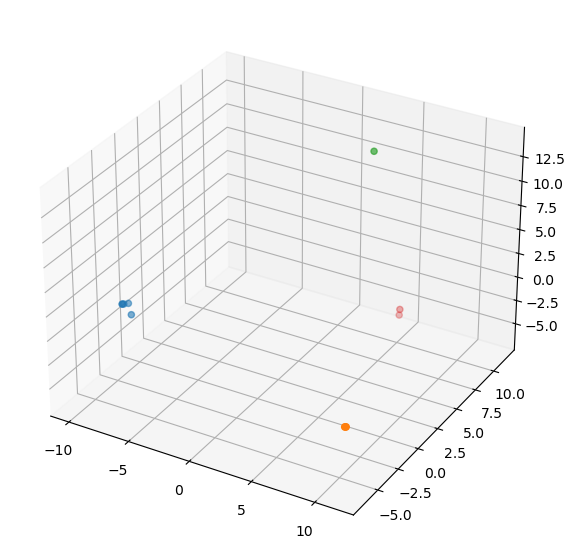

In [126]:
%matplotlib inline
fig = plt.figure(figsize = (10, 7))
ax1 = plt.axes(projection ="3d")

ax1.scatter3D(pca_features3.T[0],pca_features3.T[1],pca_features3.T[2],c=colors[M_labels[N_labels==2]])
plt.show()



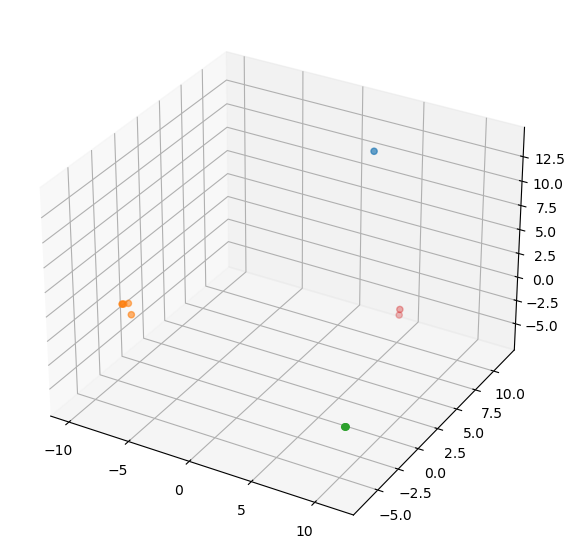

In [127]:
%matplotlib inline
fig = plt.figure(figsize = (10, 7))
ax2 = plt.axes(projection = "3d")
ax2.scatter3D(pca_features3.T[0],pca_features3.T[1],pca_features3.T[2],c=colors[kmeans.labels_])

plt.show()

In [67]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time

In [93]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=3, n_iter=300)
tsne_results = tsne.fit_transform(z_windows)

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 11 samples in 0.000s...
[t-SNE] Computed neighbors for 11 samples in 0.024s...
[t-SNE] Computed conditional probabilities for sample 11 / 11
[t-SNE] Mean sigma: 6.441201
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.085381
[t-SNE] KL divergence after 300 iterations: -0.511967


In [94]:
kmeans = KMeans(
init="random",
n_clusters=4,
n_init=10,
max_iter=300,
random_state=42
)

kmeans.fit(tsne_results)
kmeans.cluster_centers_

C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[ 60.862335,  45.29166 ],
       [ 44.215843,  25.780678],
       [ -9.846264,  -9.918406],
       [-57.544674,  18.250914]], dtype=float32)

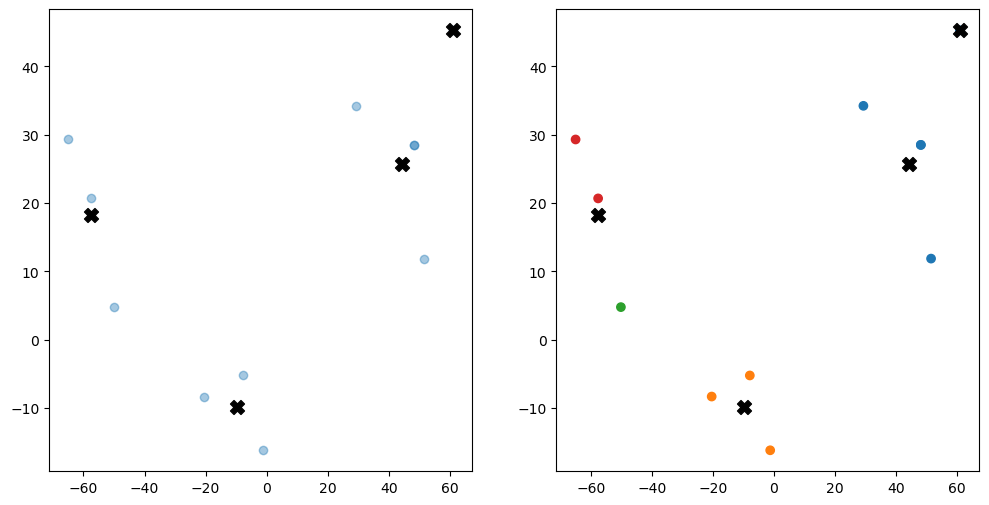

In [95]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))
ax['A'].scatter(tsne_results[:,0], tsne_results[:,1],alpha=0.4)
ax['A'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

ax['B'].scatter(tsne_results[:,0],tsne_results[:,1],c=colors[M_labels[N_labels==2]])
ax['B'].scatter(kmeans.cluster_centers_.T[0], kmeans.cluster_centers_.T[1],marker='X',color='black',s=100)

plt.show()